# Assignment 4

## Instructions
<ul>
    <li> Ensure that this assignment is your own work. PLagiarism will not be tolerated </li>
    <li> Ensure that all cells of this notebook run without error when run in order </li>
    <li> Follow the late day policy. Submit assignments on time </li>
    <li> Provide clear explanation for the algorithms you implement </li>
</ul>
Date released: 26/10/2020 

Due date: 01/11/2020 

Approximate time needed: 6-7 hours
    
## DLT and Epipolar Lines

The goal of this assignment is to aid your understanding of the Direct Linear Transform as well as Epipolar geometry.

For the first part of the assignment you will find correspondences between 2D-3D points and estimate the P Matrix. You will then be required to estimate Camera Parameters from this P matrix.

The second part of this assignment will require you to construct epipolar lines on two corresponding images.

---
## 4.1
### Generating Correspondences
The first step to perform DLT is to generate correspondences. The cell below opens a new window. Clicking anywhere on the image should give you the pixel location of the image. Once you're done clicking, close the image window. The cell after displays the points you have clicked.

In [1]:
import numpy as np

In [1]:
%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_points = []
fig = plt.figure(figsize=(20,30))

img=mpimg.imread('Images/dlt1.jpeg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    # print(ix, iy)
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

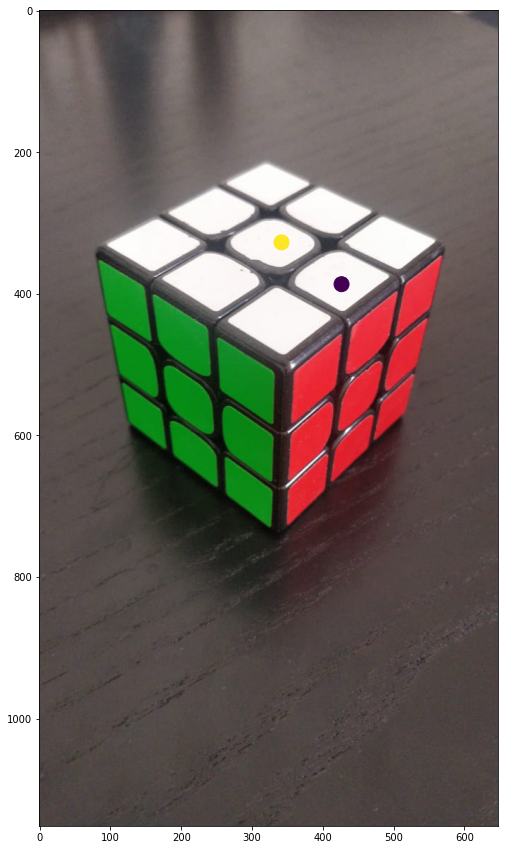

In [2]:
%matplotlib inline
N = len(image_points)
image_points = np.array(image_points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('Images/dlt1.jpeg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

After generating pixel locations, you have to generate the corresponding world points. You have the freedom to chose which point you want as origin. You can consider each side as 4 units.

Ensure that the ordering of your points matches the ordering of image points. Keep track of the sequence of corners clicked.

In [3]:
#We'll rename image_points to x to match textbook convention
x = image_points
# X represents the 3D world points
X = []
#Add your points here
#Add them as 3D points only
# X.append([1,0,0])

X = np.array(X)

Now that we have the correspondences, we can estimate the P matrix. Implement the DLT function that returns the P matrix

Quick recap: x_i = P * X_i where (x_i, X_i) is the ith correspondence, and P is a 3x4 dimensional matrix. P is further decomposed as P = K * [ R | T].


In [4]:
#Helper functions
#appends a ones column to input
def hom_coords(x,X):
    n = x.shape[0]
    size = (n,1)
    ones = np.ones(size)
    x = np.concatenate(
        (x,ones),
        axis = 1)
    X = np.concatenate(
        (X,ones),
        axis = 1)
    return x, X

x,X = hom_coords(x,X)

AxisError: axis 1 is out of bounds for array of dimension 1

#### Explanation

Edit this cell and explain the DLT algorithm:

In [ ]:
#DLT function takes as input 
#the image points and world points
#return a 3x4 matrix
def DLT(x,X):
    """
    your code here
    """
    P = np.random.randn(3,4)
    return P

P = DLT(x,X)

## Analysing P

The next part of this question is to analyse how good our estimate is. Report the reprojection error of your P matrix

In [ ]:
#Get reprojected points
def get_points(P,X):
    points = P@X.T
    points = points / points[2]
    points = points.T[:,0:2]
    return points

#Get reprojection error
def get_err(x, X, P):
    points = get_points(P, X)
    """
    find the MSE between reprojected points
    and x
    """
    #to err is to human
    return err

Given the P matrix, we can estimate K, R and T. Write a function that returns K,R,T given P.
Note: 
P = K * [R | T] where K is a 3x3 matrix and [R | T], P are 3x4 matrices

In [ ]:
def ret_RKT(P):
    """
    """
    return R, K , T 

Reproject the world points with P matrix you have obtained via DLT:

In [ ]:
re_proj = get_points(P, X)
#code to plot these on the image

### Zhangs method

For this task, use the inbuilt Opencv function to estimate the K matrix of a camera. Use the checkerboard images 5456-5470 in images/zhangs folder for this task. Familiarize yourself with the different parameters for this method.

In [ ]:
#Code for zhangs here

---
## 4.2
### Epipolar lines
#### Task 1

For this task, you have been given two images of the same scene taken from different view-points. The fundamental matrix that encodes their relative geometry as well as a subset of corresponding points have been provided to you. The images are in q2 folder.

Recall that given a point in one image, it's corresponding location in the other image can be found to along a line viz. the epipolar line. The task given to you is to draw the epipolar lines in the second image for each given point in the first image. You have to repeat this for the other image as well. Draw epipolar lines on the first image for the corresponding points in the second image.

The convention used for F is $x'^{T}Fx$ where $x'$ is the location of the point in the second image.

In [2]:
data_file = "q2/data.txt"

with open(data_file, 'r') as f:
    A = f.readlines()
    
img_points1 = A[2:12]
img_points1 = [i.strip()[:-1] for i in img_points1]
img_points1[0] = img_points1[0][1:]
img_points2 = A[15:25]
img_points2 = [i.strip()[:-1] for i in img_points2]
img_points2[0] = img_points2[0][1:]

F_mat = A[28:31]
F_mat = [i.strip()[:-1] for i in F_mat]
F_mat[0] = F_mat[0][1:]

img_1 = []
img_2 = []
F_MAT = []

for i in img_points1:
    img_1.append(np.fromstring(i[1:-1], sep=' '))
    
for i in img_points2:
    img_2.append(np.fromstring(i[1:-1], sep=' '))
    
for i in F_mat:
    F_MAT.append(np.fromstring(i[1:-1], sep=' '))

img_1 = np.array(img_1)
img_2 = np.array(img_2)
F_mat = np.array(F_MAT)

Provide a clear explanation on your approach for both this task and the next:

In [52]:
import cv2 # for drawing lines and circles on image

In [49]:
def epipolar_lines(img1_name,img2_name, points1, points2, F):
    img1 = plt.imread(img1_name)
    img2 = plt.imread(img2_name)
    r, c = img1.shape[:-1]

    for i in range(points1.shape[0]):
        # making homogenous coordinates
        point_arr = np.array([points1[i][0], points1[i][1], 1])        
        line = F @ point_arr
        # ax + by + c = 0
        x1, y1 = [0, int(-line[2] / line[1]) ] 
        x2, y2 = [c, int(-(line[2] + line[0] * c) / line[1]) ]
        color = [np.random.randint(1, 255), np.random.randint(1, 255), np.random.randint(1, 255)]
        thickness_line = 4
        thickness_point = 10
        img1 = cv2.line(img1, (x1, y1), (x2, y2), color, thickness_line) 
        img1 = cv2.circle(img1, (int(points2[i][0]), int(points2[i][1])), thickness_point, color, -1)
        img2 = cv2.circle(img2, (int(points1[i][0]), int(points1[i][1])), thickness_point, color, -1)
        
    return img1, img2

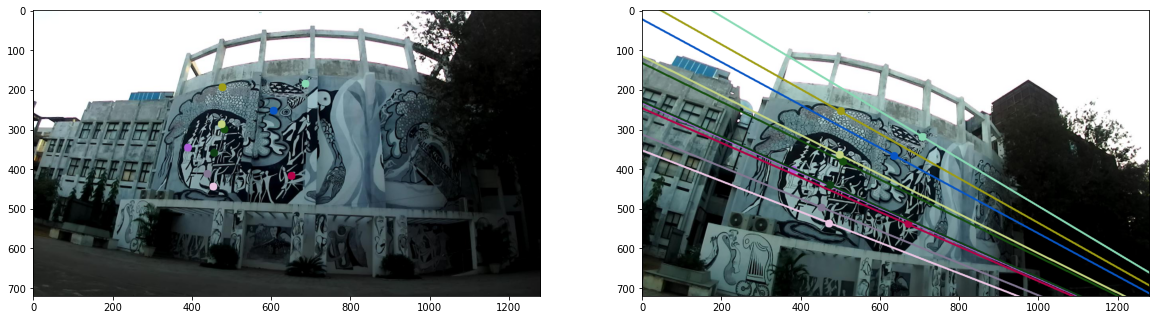

In [50]:
%matplotlib inline
H, W = 10, 10
ROWS, COLS = 1, 2
fig, ax = plt.subplots(ROWS, COLS, figsize = (H * COLS, H * ROWS)) 
ax = np.reshape(ax, (-1,))
img1, img2 = epipolar_lines('q2/img1.jpg','q2/img2.jpg', img_2, img_1, F_mat.T)
ax[0].imshow(img2)
ax[1].imshow(img1)

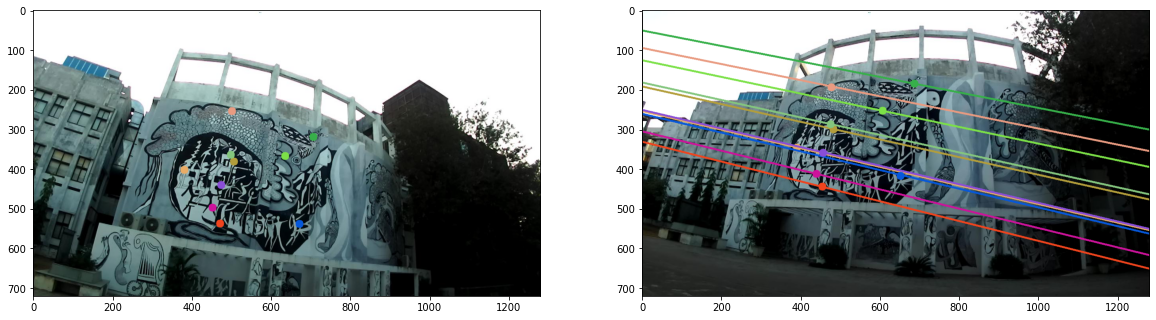

In [51]:
%matplotlib inline
H, W = 10, 10
ROWS, COLS = 1, 2
fig, ax = plt.subplots(ROWS, COLS, figsize = (H * COLS, H * ROWS)) 
ax = np.reshape(ax, (-1,))
img1, img2 = epipolar_lines('q2/img2.jpg','q2/img1.jpg', img_1, img_2, F_mat)
ax[0].imshow(img2)
ax[1].imshow(img1)

#### Task 2
Report the location of the epipoles.

In [46]:
def nullspace(A, atol=1e-13, rtol=0):
    A = np.atleast_2d(A)
    u, s, vh = np.linalg.svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    ns = vh[nnz:].conj().T
    return ns

In [47]:
nullspace(F_mat)

array([[8.75919893e-01],
       [4.82456398e-01],
       [4.05675052e-04]])

In [48]:
nullspace(F_mat.T)

array([[-9.83333374e-01],
       [-1.81811546e-01],
       [ 1.91611592e-04]])